In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.preprocessing import LabelEncoder, normalize, MaxAbsScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score, confusion_matrix
from scipy.optimize import linear_sum_assignment

In [2]:
# BEST MODEL CHOSEN: CARDIFFNLP + PCA + GMM
RANDOM_STATE       = 42
N_CLUSTERS         = 3
MAX_LEN            = 128
EMB_DIM            = 768  
PCA_N_COMPONENTS   = 44  
GMM_COV_TYPE       = "tied"

In [3]:
# -------------------- Load data --------------------
df = pd.read_csv("min_cleaned_tweets.csv")
texts = df["clean_text"].astype(str).tolist()

le = LabelEncoder()
df["y_true"] = le.fit_transform(df["airline_sentiment"].astype(str).values)

In [4]:
# -------------------- CardiffNLP Twitter RoBERTa --------------------
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"  # or "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer  = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model      = AutoModelForSequenceClassification.from_pretrained(model_name, output_hidden_states=True)

device = torch.device(
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
model.to(device).eval()
print(f"Model on device: {device}")

@torch.no_grad()
def get_hidden_and_logits(texts, batch_size=32, layer=-2, max_length=MAX_LEN):
    """Mean-pool a hidden layer + grab classifier logits."""
    h_list, logit_list = [], []
    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding+Logits (CardiffNLP)"):
        batch = texts[i:i+batch_size]
        toks = tokenizer(batch, padding=True, truncation=True,
                         max_length=max_length, return_tensors="pt").to(device)
        out  = model(**toks, output_hidden_states=True)
        hs   = out.hidden_states[layer].mean(dim=1).cpu().numpy()  # [B, H]
        h_list.append(hs)
        logit_list.append(out.logits.detach().cpu().numpy())      # [B, 3]
    H = np.vstack(h_list).astype(np.float64)
    L = np.vstack(logit_list).astype(np.float64)
    return H, L

# 1) Embeddings + logits → hybrid features
X_emb, X_logits = get_hidden_and_logits(texts)
X_hybrid        = np.concatenate([X_emb, X_logits], axis=1).astype(np.float64)

# 2) PCA reduction (match your pipeline’s scaler choice)
X_std = MaxAbsScaler().fit_transform(X_hybrid)
pca   = PCA(n_components=PCA_N_COMPONENTS, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_std)      # shape: [N, 44]

# 3) GMM clustering (covariance tied)
gmm = GaussianMixture(
    n_components=N_CLUSTERS,
    covariance_type=GMM_COV_TYPE,
    n_init=10,
    random_state=RANDOM_STATE,
    reg_covar=1e-6
)
labels_raw = gmm.fit_predict(X_pca)
df["cluster_raw"] = labels_raw

# 4) Hungarian mapping: cluster -> sentiment id
def hungarian_map(y_true, y_pred, n_classes=N_CLUSTERS):
    C = confusion_matrix(y_true, y_pred, labels=range(n_classes))
    r, c = linear_sum_assignment(C.max() - C)     # maximize matches
    mapping = {pred_cluster: true_label for pred_cluster, true_label in zip(c, r)}
    y_mapped = np.array([mapping.get(k, k) for k in y_pred], dtype=int)
    acc = C[r, c].sum() / C.sum()
    return y_mapped, mapping, acc, C

y_pred_mapped, map_dict, hung_acc, cm_before = hungarian_map(df["y_true"].values, df["cluster_raw"].values)
df["pred_label_int"]   = y_pred_mapped
df["pred_label"]       = le.inverse_transform(df["pred_label_int"])
df["is_misclassified"] = (df["pred_label_int"] != df["y_true"]).astype(int)

print(f"Hungarian Accuracy = {hung_acc:.3f}")
print("Cluster → Label mapping:", map_dict)

# 5) Confidence diagnostics
# (a) Silhouette in PCA space, Euclidean (matches GMM branch)
sil_metric = "euclidean"
sil_global = silhouette_score(X_pca, df["cluster_raw"], metric=sil_metric)
sil_each   = silhouette_samples(X_pca, df["cluster_raw"], metric=sil_metric)
df["confidence_silhouette"] = sil_each
print(f"Global Silhouette (clusters, euclidean): {sil_global:.3f}")

# (b) Sentiment confidence from classifier logits (softmax max-prob)
def softmax(z):
    z = z - z.max(axis=1, keepdims=True)
    e = np.exp(z)
    return e / e.sum(axis=1, keepdims=True)

probs = softmax(X_logits)
df["sentiment_confidence"] = probs.max(axis=1)

print("\nMisclassification rate:", df["is_misclassified"].mean().round(3))

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model on device: mps


Embedding+Logits (CardiffNLP):   0%|          | 0/458 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/501M [00:00<?, ?B/s]

Embedding+Logits (CardiffNLP): 100%|██████████| 458/458 [03:03<00:00,  2.50it/s]


Hungarian Accuracy = 0.806
Cluster → Label mapping: {np.int64(0): np.int64(0), np.int64(1): np.int64(1), np.int64(2): np.int64(2)}
Global Silhouette (clusters, euclidean): 0.305

Misclassification rate: 0.194


Confusion matrix (counts):
 pred_label         negative  neutral  positive
airline_sentiment                             
negative               8000      983       195
neutral                 856     1849       394
positive                 81      325      1956

Confusion matrix (row-normalized):
 pred_label         negative  neutral  positive
airline_sentiment                             
negative              0.872    0.107     0.021
neutral               0.276    0.597     0.127
positive              0.034    0.138     0.828


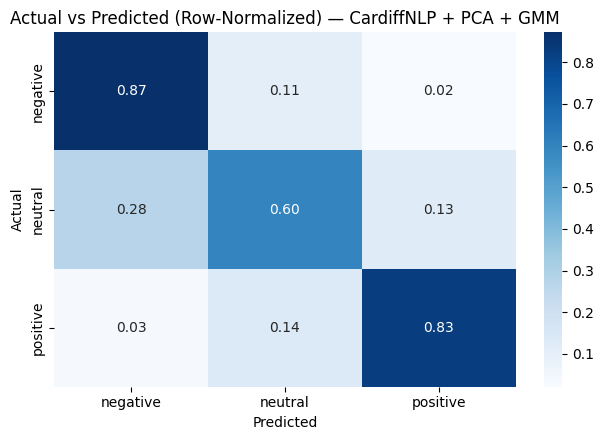

In [6]:
# Confusion (actual rows × predicted cols)
labels_order = list(le.classes_)  
cm_counts = pd.crosstab(df["airline_sentiment"], df["pred_label"])
cm_norm   = cm_counts.div(cm_counts.sum(axis=1), axis=0)

print("Confusion matrix (counts):\n", cm_counts)
print("\nConfusion matrix (row-normalized):\n", cm_norm.round(3))

plt.figure(figsize=(6.5, 4.5))
sns.heatmap(cm_norm.loc[labels_order], annot=True, fmt=".2f", cmap="Blues")
plt.title("Actual vs Predicted (Row-Normalized) — CardiffNLP + PCA + GMM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

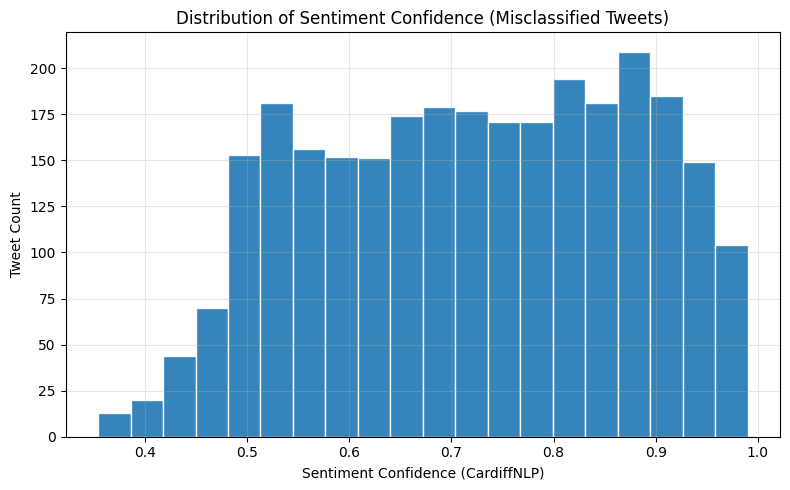

In [7]:
# plot: the distribution of the confidence level of the misclassified cluster
df_mis = df[df['is_misclassified'] == 1].reset_index(drop=True)
plt.figure(figsize=(8,5))
plt.hist(df_mis["sentiment_confidence"], bins=20, edgecolor="white", alpha=0.9)
plt.title("Distribution of Sentiment Confidence (Misclassified Tweets)")
plt.xlabel("Sentiment Confidence (CardiffNLP)")
plt.ylabel("Tweet Count")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()